In [1]:
# NB: Start an ImageJ server before you run this!
#
#   git clone git://github.com/imagej/imagej-server
#   cd image-server
#   mvn -Pexec

import imagej
ij = imagej.IJ()

In [2]:
frangi = ij.find('FrangiVesselness')[0]

In [3]:
# Dump information about the module ID and inputs.
frangi_details = ij.detail(frangi)
print(frangi_details['identifier'])
[
    {k: input[k] for k in ['name', 'genericType', 'required']} for input in frangi_details['inputs']
]

command:net.imagej.ops.commands.filter.FrangiVesselness


[{'genericType': u'interface org.scijava.log.LogService',
  'name': u'log',
  'required': True},
 {'genericType': u'interface net.imagej.ops.OpService',
  'name': u'opService',
  'required': True},
 {'genericType': u'net.imglib2.img.Img<capture of ?>',
  'name': u'input',
  'required': True},
 {'genericType': u'boolean', 'name': u'doGauss', 'required': True},
 {'genericType': u'class java.lang.String',
  'name': u'spacingString',
  'required': True},
 {'genericType': u'class java.lang.String',
  'name': u'scaleString',
  'required': True}]

In [4]:
# Upload an image.
cells_id = ij.upload('data/images/cells-16bit.tif')
cells_id

u'object:jdm9qlr271cq9prf'

In [5]:
# Define a utility function to convert from string data to PIL image
from PIL import Image
import StringIO
def data2image(data):
    return Image.open(StringIO.StringIO(data))

In [6]:
# Define a utility function to show an image using matplotlib.
from matplotlib import pyplot as plt
def show(image):
    plt.imshow(image, interpolation='nearest')
    plt.show()

In [7]:
# retrieve input image as PNG data.
cells_png = ij.retrieve(cells_id, format='png')
len(cells_png)

62484

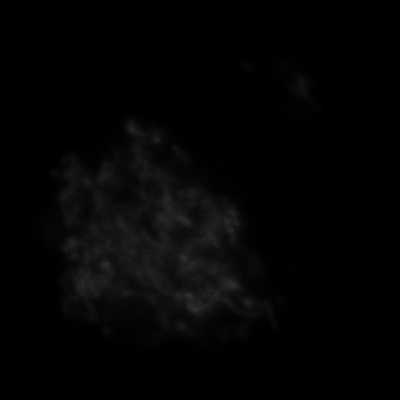

In [8]:
# convert image data to PIL image.
cells_pil = data2image(cells_png)
cells_pil

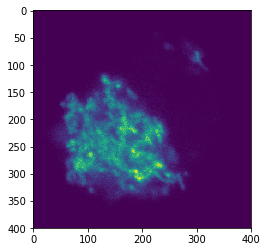

In [9]:
# We can also convert a PIL image to numpy array as needed.
import numpy as np
cells_np = np.array(cells_pil)
show(cells_np)

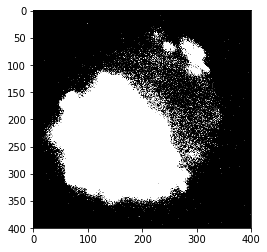

In [10]:
# Strangely, we can also ask matplotlib to show a PIL image... but it's not so nice.
show(cells_pil)

In [11]:
# Execute module on the ImageJ server side.
result = ij.run(frangi, {'input': cells_id, 'doGauss': True, 'spacingString': '1, 1', 'scaleString': '2, 5'})
vessels_id = result['result']
vessels_id

u'object:jdm9qmothe7vk08r'

In [12]:
# We cannot retrieve the vessels output image as a PNG, because it is multiple planes
# (or is it because it is 32-bit floats? test this to be certain).
# The ImageJ Server will give us a 409 error because it cannot export to PNG.
vessels_png = ij.retrieve(vessels_id, format='png')

HTTPError: 409 Client Error: Conflict for url: http://localhost:8080/objects/object:jdm9qmothe7vk08r/png

In [13]:
# So, we retrieve the resultant image in TIFF format instead.
vessels_tif = ij.retrieve(vessels_id, format='tif')
len(vessels_tif)

1283614

In [14]:
# Unfortunately, the TIFF data coming back is corrupted. :-(
# PIL cannot read it, nor can ImageJ if it is dumped to disk.
vessels_pil = data2image(vessels_tif)
vessels_pil

IOError: image file is truncated (0 bytes not processed)

<PIL.TiffImagePlugin.TiffImageFile image mode=F size=400x400 at 0x10FD43F10>

In [15]:
# Use a script to whittle down the image to a single plane.
script_eval = ij.find('ScriptEval')[0]

import os
first_plane_script = os.path.abspath('first_plane.py')

script = """
#@ OpService ops
#@ Img image
#@output Object result
result = image
while (result.numDimensions() > 2):
    result = ops.transform().hyperSliceView(result, 2, 0)
"""

result = ij.run(script_eval, {'language': 'python', 'script': script, 'args': {'image': vessels_id}})
plane_id = result['outputs']['result']
plane_id

u'object:jdm9qtf0ku0ljed0'

In [16]:
# And now we retrieve the single plane as a PNG.

# CTR START HERE - Figure out why we are getting a 400 error here.
# It does not work to retrieve as TIFF, either -- same error.
# Possible reasons:
# - object is not an image?
# - script did not complete successfully?

plane_png = ij.retrieve(plane_id, format='png')
len(plane_png)

HTTPError: 400 Client Error: Bad Request for url: http://localhost:8080/objects/object:jdm9qtf0ku0ljed0/png